In [1]:
import numpy as np
from skimage.feature import corner_harris, peak_local_max


def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x,c)


<>:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-1-844524c8c786>:50: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [2]:
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [3]:
originalImage = cv2.imread("imageproxy.jpg") # open colour image
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
h, coords = get_harris_corners(blackAndWhiteImage)

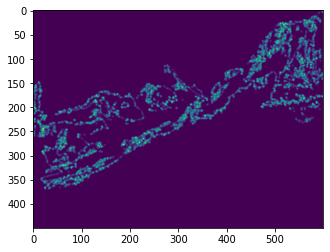

In [4]:
plt.imshow(h)

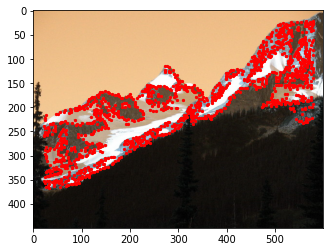

In [5]:
implot = plt.imshow(originalImage)
plt.scatter(x=coords[1], y=coords[0], c='r', s=5)
plt.show()

In [6]:
# Adaptive Non-Maximal Suppression
def anms(coords,h,top=500):
    l = []
    for x in range(np.shape(coords)[1]):
        minpoint = 1000000
        xi, yi = coords[0][x], coords[1][x]
        for y in range(np.shape(coords)[1]): 
            xj, yj = coords[0][y], coords[1][y]
            if (xi != xj and yi != yj) and h[xi,yi] < 0.9 * h[xj,yj]:
                dist = dist2(coords[:,x:x+1].T,coords[:,y:y+1].T)[0][0]
                if dist < minpoint:
                    minpoint = dist
        l.append([xi, yi, minpoint])
        
    l.sort(key=lambda x: x[2])
    l = l[0:top]
    return l

In [7]:
l=anms(coords,h)
implot = plt.imshow(originalImage)
plt.scatter(x=np.array(l)[:,1], y=np.array(l)[:,0], c='r', s=5)
plt.show()

In [8]:
def mops(x,y,win_size,img):
    x=int(x)
    y=int(y)
    offset = win_size // 2
    win = img[x-offset:x+offset, y-offset:y+offset]
    s = win_size // 8
    rows = []
    for i in range(0,win_size,s):
        cols = []
        for j in range(0,win_size,s):
            sample = win[i:i+s, j:j+s]
            sample = np.sum(sample) / (s*s)
            cols.append(sample)
        rows.append(cols)
    
    feature = np.array(rows)
    feature = (feature - np.mean(feature)) / np.std(feature)
    return feature

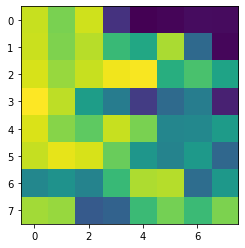

In [12]:
feature=mops(np.array(l)[2,0],np.array(l)[2,1],40,originalImage)
plt.imshow(feature)

In [64]:
def match(l1,l2,f1,f2):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(f2)
    distances, indices = nbrs.kneighbors(f1)
    ratio=np.zeros((distances.shape[0],1))
    ratio = (distances[:,0]/distances[:,1])**2
    result=[]
    for i in range(distances.shape[0]):
        if ratio[i]<0.3:
            xi, yi = l1[i,0],l1[i,1]
            xj, yj = l2[indices[i,0],0],l2[indices[i,0],1]
            result.append([xi,yi,xj,yj])
    return result

In [43]:
feature=mops(np.array(l)[0,0],np.array(l)[0,1],40,originalImage)
feature=np.array(feature.flatten())
for i in range(np.shape(l)[0]-1):
    a=mops(np.array(l)[i+1,0],np.array(l)[i+1,1],40,originalImage)
    feature=np.vstack((feature,np.array(a.flatten())))

### Step 1-3 (Target)

In [54]:
originalImage = cv2.imread("1.jpg") # open colour image
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
h, coords = get_harris_corners(blackAndWhiteImage)

originalImage2 = cv2.imread("2.jpg") # open colour image
grayImage2 = cv2.cvtColor(originalImage2, cv2.COLOR_BGR2GRAY)
(thresh2, blackAndWhiteImage2) = cv2.threshold(grayImage2, 127, 255, cv2.THRESH_BINARY)
h2, coords2 = get_harris_corners(blackAndWhiteImage2)

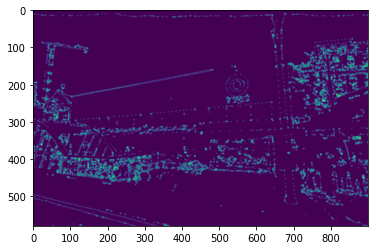

In [55]:
plt.imshow(h)

In [56]:
plt.imshow(h2)

In [57]:
implot = plt.imshow(originalImage)
plt.scatter(x=coords[1], y=coords[0], c='r', s=5)
plt.show()

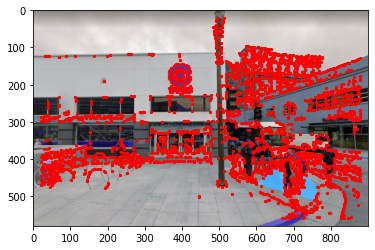

In [58]:
implot = plt.imshow(originalImage2)
plt.scatter(x=coords2[1], y=coords2[0], c='r', s=5)
plt.show()

In [59]:
l=anms(coords,h)
implot = plt.imshow(originalImage)
plt.scatter(x=np.array(l)[:,1], y=np.array(l)[:,0], c='r', s=5)
plt.show()

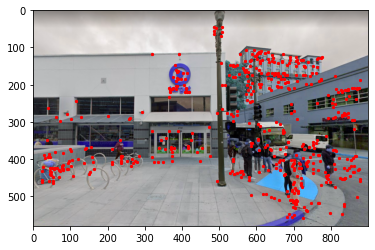

In [60]:
l2=anms(coords2,h2)
implot2 = plt.imshow(originalImage2)
plt.scatter(x=np.array(l2)[:,1], y=np.array(l2)[:,0], c='r', s=5)
plt.show()

In [61]:
feature=mops(np.array(l)[0,0],np.array(l)[0,1],40,originalImage)
feature=np.array(feature.flatten())
for i in range(np.shape(l)[0]-1):
    a=mops(np.array(l)[i+1,0],np.array(l)[i+1,1],40,originalImage)
    feature=np.vstack((feature,np.array(a.flatten())))

In [62]:
feature2=mops(np.array(l2)[0,0],np.array(l2)[0,1],40,originalImage2)
feature2=np.array(feature2.flatten())
for i in range(np.shape(l2)[0]-1):
    a=mops(np.array(l2)[i+1,0],np.array(l2)[i+1,1],40,originalImage2)
    feature2=np.vstack((feature2,np.array(a.flatten())))

In [72]:
result=match(np.array(l),np.array(l2),feature,feature2)

In [73]:
result

[[248.0, 523.0, 219.0, 368.0],
 [372.0, 405.0, 350.0, 232.0],
 [429.0, 486.0, 407.0, 324.0],
 [396.0, 292.0, 378.0, 101.0],
 [240.0, 527.0, 212.0, 373.0],
 [180.0, 696.0, 174.0, 527.0],
 [415.0, 408.0, 397.0, 236.0],
 [399.0, 513.0, 374.0, 353.0],
 [391.0, 579.0, 364.0, 417.0],
 [417.0, 481.0, 395.0, 319.0],
 [391.0, 303.0, 374.0, 100.0],
 [244.0, 569.0, 220.0, 413.0],
 [211.0, 550.0, 184.0, 397.0],
 [211.0, 542.0, 184.0, 390.0]]

In [74]:
implot = plt.imshow(originalImage)
plt.scatter(x=np.array(result)[:,1], y=np.array(result)[:,0], c='r', s=5)
plt.show()

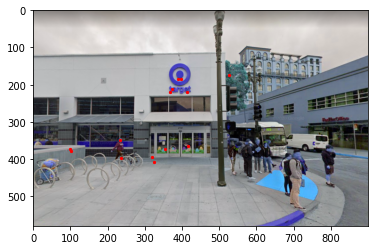

In [76]:
implot = plt.imshow(originalImage2)
plt.scatter(x=np.array(result)[:,3], y=np.array(result)[:,2], c='r', s=5)
plt.show()

In [78]:
import pandas as pd
dataFrameForSolution = pd.DataFrame(result) 
#Save to xlsx file
filepath = 'result1.xlsx'
dataFrameForSolution.to_excel(filepath, index=False)

### Step 1-3 (School)

In [120]:
originalImage = cv2.imread("3.jpg") # open colour image
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
h, coords = get_harris_corners(blackAndWhiteImage)

originalImage2 = cv2.imread("4.jpg") # open colour image
grayImage2 = cv2.cvtColor(originalImage2, cv2.COLOR_BGR2GRAY)
(thresh2, blackAndWhiteImage2) = cv2.threshold(grayImage2, 127, 255, cv2.THRESH_BINARY)
h2, coords2 = get_harris_corners(blackAndWhiteImage2)

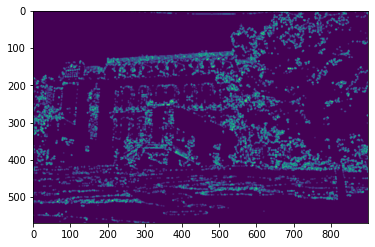

In [121]:
plt.imshow(h)

In [122]:
plt.imshow(h2)

In [123]:
implot = plt.imshow(originalImage)
plt.scatter(x=coords[1], y=coords[0], c='r', s=5)
plt.show()

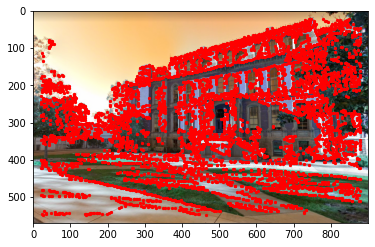

In [124]:
implot = plt.imshow(originalImage2)
plt.scatter(x=coords2[1], y=coords2[0], c='r', s=5)
plt.show()

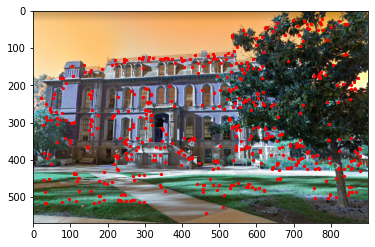

In [125]:
l=anms(coords,h)
implot = plt.imshow(originalImage)
plt.scatter(x=np.array(l)[:,1], y=np.array(l)[:,0], c='r', s=5)
plt.show()

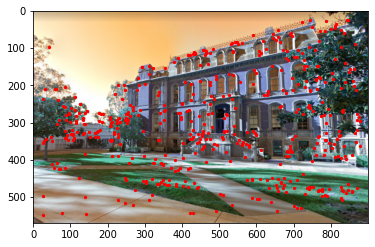

In [126]:
l2=anms(coords2,h2)
implot2 = plt.imshow(originalImage2)
plt.scatter(x=np.array(l2)[:,1], y=np.array(l2)[:,0], c='r', s=5)
plt.show()

In [127]:
feature=mops(np.array(l)[0,0],np.array(l)[0,1],40,originalImage)
feature=np.array(feature.flatten())
for i in range(np.shape(l)[0]-1):
    a=mops(np.array(l)[i+1,0],np.array(l)[i+1,1],40,originalImage)
    feature=np.vstack((feature,np.array(a.flatten())))

In [128]:
feature2=mops(np.array(l2)[0,0],np.array(l2)[0,1],40,originalImage2)
feature2=np.array(feature2.flatten())
for i in range(np.shape(l2)[0]-1):
    a=mops(np.array(l2)[i+1,0],np.array(l2)[i+1,1],40,originalImage2)
    feature2=np.vstack((feature2,np.array(a.flatten())))

In [129]:
result=match(np.array(l),np.array(l2),feature,feature2)

In [130]:
result

[[354.0, 372.0, 330.0, 540.0],
 [317.0, 258.0, 297.0, 425.0],
 [382.0, 393.0, 358.0, 560.0],
 [380.0, 389.0, 358.0, 560.0],
 [425.0, 225.0, 395.0, 402.0],
 [414.0, 397.0, 393.0, 569.0],
 [386.0, 325.0, 361.0, 493.0],
 [351.0, 291.0, 327.0, 456.0],
 [222.0, 316.0, 199.0, 476.0],
 [144.0, 212.0, 137.0, 379.0],
 [131.0, 309.0, 108.0, 465.0],
 [387.0, 405.0, 365.0, 579.0]]

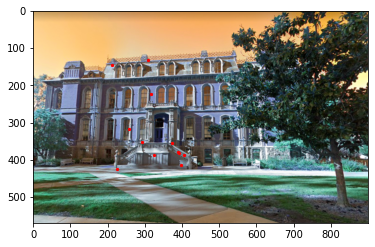

In [131]:
implot = plt.imshow(originalImage)
plt.scatter(x=np.array(result)[:,1], y=np.array(result)[:,0], c='r', s=5)
plt.show()

In [132]:
implot = plt.imshow(originalImage2)
plt.scatter(x=np.array(result)[:,3], y=np.array(result)[:,2], c='r', s=5)
plt.show()

In [133]:
import pandas as pd
dataFrameForSolution = pd.DataFrame(result) 
#Save to xlsx file
filepath = 'result2.xlsx'
dataFrameForSolution.to_excel(filepath, index=False)

### Step 1-3 (School2)

In [175]:
originalImage = cv2.imread("e1.jpg") # open colour image
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
h, coords = get_harris_corners(blackAndWhiteImage)

originalImage2 = cv2.imread("e2.jpg") # open colour image
grayImage2 = cv2.cvtColor(originalImage2, cv2.COLOR_BGR2GRAY)
(thresh2, blackAndWhiteImage2) = cv2.threshold(grayImage2, 127, 255, cv2.THRESH_BINARY)
h2, coords2 = get_harris_corners(blackAndWhiteImage2)

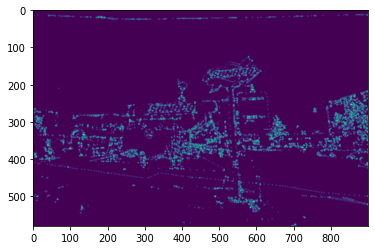

In [176]:
plt.imshow(h)

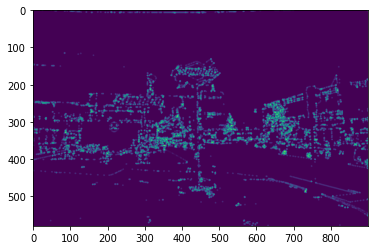

In [177]:
plt.imshow(h2)

In [178]:
implot = plt.imshow(originalImage)
plt.scatter(x=coords[1], y=coords[0], c='r', s=5)
plt.show()

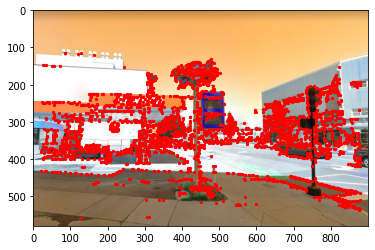

In [179]:
implot = plt.imshow(originalImage2)
plt.scatter(x=coords2[1], y=coords2[0], c='r', s=5)
plt.show()

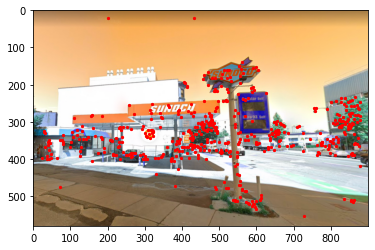

In [180]:
l=anms(coords,h)
implot = plt.imshow(originalImage)
plt.scatter(x=np.array(l)[:,1], y=np.array(l)[:,0], c='r', s=5)
plt.show()

In [181]:
l2=anms(coords2,h2)
implot2 = plt.imshow(originalImage2)
plt.scatter(x=np.array(l2)[:,1], y=np.array(l2)[:,0], c='r', s=5)
plt.show()

In [182]:
feature=mops(np.array(l)[0,0],np.array(l)[0,1],40,originalImage)
feature=np.array(feature.flatten())
for i in range(np.shape(l)[0]-1):
    a=mops(np.array(l)[i+1,0],np.array(l)[i+1,1],40,originalImage)
    feature=np.vstack((feature,np.array(a.flatten())))

In [183]:
feature2=mops(np.array(l2)[0,0],np.array(l2)[0,1],40,originalImage2)
feature2=np.array(feature2.flatten())
for i in range(np.shape(l2)[0]-1):
    a=mops(np.array(l2)[i+1,0],np.array(l2)[i+1,1],40,originalImage2)
    feature2=np.vstack((feature2,np.array(a.flatten())))

In [184]:
result=match(np.array(l),np.array(l2),feature,feature2)

In [185]:
result

[[470.0, 553.0, 444.0, 448.0],
 [329.0, 319.0, 310.0, 225.0],
 [299.0, 481.0, 285.0, 390.0],
 [218.0, 486.0, 207.0, 399.0],
 [515.0, 572.0, 482.0, 459.0],
 [441.0, 331.0, 428.0, 240.0],
 [374.0, 426.0, 359.0, 336.0],
 [369.0, 417.0, 353.0, 328.0],
 [367.0, 405.0, 351.0, 317.0],
 [360.0, 452.0, 343.0, 360.0],
 [334.0, 435.0, 318.0, 346.0],
 [331.0, 495.0, 316.0, 402.0],
 [325.0, 445.0, 309.0, 357.0],
 [314.0, 454.0, 299.0, 363.0],
 [219.0, 524.0, 208.0, 430.0],
 [513.0, 600.0, 478.0, 481.0],
 [385.0, 506.0, 367.0, 409.0],
 [353.0, 523.0, 337.0, 425.0],
 [342.0, 305.0, 324.0, 211.0],
 [308.0, 472.0, 293.0, 381.0],
 [288.0, 396.0, 271.0, 310.0],
 [271.0, 488.0, 260.0, 394.0],
 [245.0, 518.0, 235.0, 425.0],
 [243.0, 497.0, 232.0, 406.0],
 [201.0, 471.0, 189.0, 385.0],
 [387.0, 348.0, 371.0, 259.0],
 [381.0, 435.0, 364.0, 345.0],
 [377.0, 458.0, 360.0, 367.0],
 [367.0, 412.0, 351.0, 323.0],
 [350.0, 569.0, 334.0, 466.0],
 [328.0, 323.0, 309.0, 229.0],
 [303.0, 471.0, 288.0, 381.0],
 [281.0,

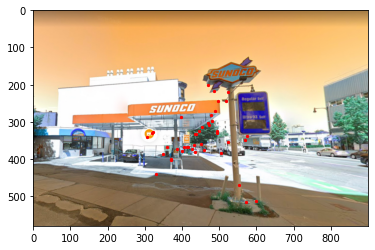

In [186]:
implot = plt.imshow(originalImage)
plt.scatter(x=np.array(result)[:,1], y=np.array(result)[:,0], c='r', s=5)
plt.show()

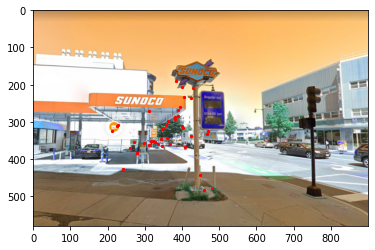

In [187]:
implot = plt.imshow(originalImage2)
plt.scatter(x=np.array(result)[:,3], y=np.array(result)[:,2], c='r', s=5)
plt.show()

In [188]:
import pandas as pd
dataFrameForSolution = pd.DataFrame(result) 
#Save to xlsx file
filepath = 'result3.xlsx'
dataFrameForSolution.to_excel(filepath, index=False)